# PINNs for the 1D Heat Equation (JAX)
This notebook trains two Physics-Informed Neural Networks (PINNs) with JAX, Equinox, and Optax to solve the 1D heat equation with homogeneous Dirichlet boundary conditions. We mirror the PyTorch workflow with soft- and hard-constraint formulations.

## Problem setup
We solve the dimensionless heat equation
$$ u_t = \alpha u_{xx}, \quad x \in [0, 1], \; t \in [0, 1] $$
with Dirichlet boundaries $u(0, t) = u(1, t) = 0$ and initial condition $u(x, 0) = \sin(\pi x)$. The analytic solution is $u(x, t) = e^{-\alpha \pi^2 t} \sin(\pi x)$, which we use for supervision at $t=0$ and for qualitative evaluation.

In [13]:
import math
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pandas as pd

USE_64 = False  # float64 is slower on most accelerators; toggle if you need extra precision.
jax.config.update("jax_enable_x64", USE_64)

key = jrandom.PRNGKey(42)
print(f"JAX devices: {jax.devices()}")


JAX devices: [CpuDevice(id=0)]


In [14]:
ALPHA = 0.1
X_MIN, X_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

def initial_condition(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.sin(jnp.pi * x)

def exact_solution(x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    return jnp.exp(-ALPHA * (math.pi ** 2) * t) * jnp.sin(math.pi * x)

def sample_interior(key: jax.Array, n: int):
    key_x, key_t = jrandom.split(key)
    x = jrandom.uniform(key_x, (n,), minval=X_MIN, maxval=X_MAX)
    t = jrandom.uniform(key_t, (n,), minval=T_MIN, maxval=T_MAX)
    return x, t

def sample_initial(key: jax.Array, n: int):
    x = jrandom.uniform(key, (n,), minval=X_MIN, maxval=X_MAX)
    t = jnp.zeros_like(x) + T_MIN
    return x, t

def sample_boundary(key: jax.Array, n: int):
    key_left, key_right = jrandom.split(key)
    t_left = jrandom.uniform(key_left, (n,), minval=T_MIN, maxval=T_MAX)
    t_right = jrandom.uniform(key_right, (n,), minval=T_MIN, maxval=T_MAX)
    x_left = jnp.zeros_like(t_left) + X_MIN
    x_right = jnp.zeros_like(t_right) + X_MAX
    return (x_left, t_left), (x_right, t_right)

In [15]:
class HeatPINN(eqx.Module):
    mlp: eqx.nn.MLP
    hard_boundary: bool = eqx.field(static=True)
    hard_initial: bool = eqx.field(static=True)

    def __call__(self, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
        inputs = jnp.stack([x, t], axis=-1)
        out = self.mlp(inputs)
        if self.hard_boundary:
            xi = (x - X_MIN) / (X_MAX - X_MIN)
            out = xi * (1.0 - xi) * out
        if self.hard_initial:
            # Time ramp enforces u(x, T_MIN) = initial_condition(x).
            tau = (t - T_MIN) / (T_MAX - T_MIN)
            out = initial_condition(x) + tau * out
        return jnp.squeeze(out, axis=-1)

def make_model(key, *, hidden_layers: int = 4, hidden_width: int = 64, hard_boundary: bool = False, hard_initial: bool = False) -> HeatPINN:
    mlp = eqx.nn.MLP(
        in_size=2,
        out_size=1,
        width_size=hidden_width,
        depth=hidden_layers,
        activation=jnp.tanh,
        key=key,
    )
    return HeatPINN(mlp=mlp, hard_boundary=hard_boundary, hard_initial=hard_initial)

def pde_residual(model: HeatPINN, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    u = lambda x0, t0: model(x0, t0)
    u_t = jax.grad(u, argnums=1)(x, t)
    u_x = jax.grad(u, argnums=0)(x, t)
    u_xx = jax.grad(lambda x0, t0: jax.grad(u, argnums=0)(x0, t0), argnums=0)(x, t)
    return u_t - ALPHA * u_xx


In [16]:
def train_pinn(*, steps: int = 2500, lr: float = 1e-3, interior_samples: int = 1024, boundary_samples: int = 256, initial_samples: int = 256, hard_boundary: bool = False, hard_initial: bool = False, seed: int = 42):
    key = jrandom.PRNGKey(seed)
    model_key, key = jrandom.split(key)
    model = make_model(model_key, hard_boundary=hard_boundary, hard_initial=hard_initial)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    history = []

    def loss_fn(model: HeatPINN, key: jax.Array):
        key, int_key, init_key, bc_key = jrandom.split(key, 4)

        x_i, t_i = sample_interior(int_key, interior_samples)

        residual = jax.vmap(pde_residual, in_axes=(None, 0, 0))(model, x_i, t_i)
        loss_residual = jnp.mean(residual ** 2)

        loss_initial = jnp.array(0.0)
        if not model.hard_initial:
            x_init, t_init = sample_initial(init_key, initial_samples)
            u_init = jax.vmap(lambda x, t: model(x, t))(x_init, t_init)
            target_init = exact_solution(x_init, t_init)
            loss_initial = jnp.mean((u_init - target_init) ** 2)

        loss_boundary = jnp.array(0.0)
        if not model.hard_boundary:
            (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(bc_key, boundary_samples)
            u_b0 = jax.vmap(lambda x, t: model(x, t))(x_b0, t_b0)
            u_b1 = jax.vmap(lambda x, t: model(x, t))(x_b1, t_b1)
            loss_boundary = jnp.mean(u_b0 ** 2) + jnp.mean(u_b1 ** 2)

        total = loss_residual + loss_initial + loss_boundary
        return total, (loss_residual, loss_initial, loss_boundary)

    # JIT-compile the loss/grad and the optimizer step to remove Python overhead in the loop.
    loss_and_grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)
    loss_and_grads = eqx.filter_jit(loss_and_grads)

    @eqx.filter_jit
    def train_step(model, opt_state, key):
        (loss_value, (lres, linit, lbc)), grads = loss_and_grads(model, key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value, lres, linit, lbc

    for step in range(1, steps + 1):
        key, step_key = jrandom.split(key)
        model, opt_state, loss_value, lres, linit, lbc = train_step(model, opt_state, step_key)

        history.append({
            "step": step,
            "loss": float(loss_value),
            "residual": float(lres),
            "initial": float(linit),
            "boundary": float(lbc),
        })

        if step % 500 == 0 or step == 1:
            if hard_boundary and hard_initial:
                tag = "hard-bc+ic"
            elif hard_boundary:
                tag = "hard-bc"
            elif hard_initial:
                tag = "hard-ic"
            else:
                tag = "soft"
            msg = f"[{tag}] step {step:4d} | total={loss_value:.3e} | residual={lres:.3e} | init={linit:.3e}"
            if not hard_boundary:
                msg += f" | bc={lbc:.3e}"
            print(msg)

    return model, history


## Soft-constraint PINN
Boundary conditions are enforced by adding their residuals to the loss (classical soft-constraint PINN).

In [17]:
soft_model, soft_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=False,
    seed=123,
)

[soft] step    1 | total=5.236e-01 | residual=2.289e-04 | init=5.211e-01 | bc=2.314e-03
[soft] step  500 | total=5.118e-04 | residual=4.002e-04 | init=4.270e-05 | bc=6.884e-05
[soft] step 1000 | total=1.100e-04 | residual=1.031e-04 | init=3.582e-06 | bc=3.262e-06
[soft] step 1500 | total=1.174e-04 | residual=9.423e-05 | init=6.061e-06 | bc=1.709e-05
[soft] step 2000 | total=8.837e-05 | residual=7.537e-05 | init=4.108e-06 | bc=8.893e-06
[soft] step 2500 | total=8.924e-04 | residual=6.577e-05 | init=3.018e-04 | bc=5.249e-04


## Hard-constraint PINNs
The network output can be wrapped in $x (1 - x)$ so that $u(0, t) = u(1, t) = 0$ is satisfied exactly. To also enforce the initial condition, use a time ramp,
$$ u(x, t) = u_0(x) + (t - T_{\min}) x (1 - x) \, \mathrm{NN}(x, t), $$
which assumes $u_0$ already matches the boundary conditions.


In [18]:
hard_model, hard_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=True,
    hard_initial=False,
    seed=456,
)

hard_ic_model, hard_ic_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=True,
    hard_initial=True,
    seed=789,
)


[hard-bc] step    1 | total=4.783e-01 | residual=1.646e-04 | init=4.781e-01
[hard-bc] step  500 | total=3.473e-05 | residual=3.177e-05 | init=2.963e-06
[hard-bc] step 1000 | total=7.696e-06 | residual=6.494e-06 | init=1.201e-06
[hard-bc] step 1500 | total=4.204e-06 | residual=3.236e-06 | init=9.683e-07
[hard-bc] step 2000 | total=5.009e-06 | residual=3.989e-06 | init=1.020e-06
[hard-bc] step 2500 | total=6.309e-05 | residual=4.819e-05 | init=1.490e-05
[hard-bc+ic] step    1 | total=5.151e-01 | residual=5.151e-01 | init=0.000e+00
[hard-bc+ic] step  500 | total=3.053e-05 | residual=3.053e-05 | init=0.000e+00
[hard-bc+ic] step 1000 | total=1.214e-05 | residual=1.214e-05 | init=0.000e+00
[hard-bc+ic] step 1500 | total=4.462e-06 | residual=4.462e-06 | init=0.000e+00
[hard-bc+ic] step 2000 | total=2.419e-06 | residual=2.419e-06 | init=0.000e+00
[hard-bc+ic] step 2500 | total=4.202e-06 | residual=4.202e-06 | init=0.000e+00


In [19]:
def evaluate_model(model: HeatPINN, num_x: int = 100, num_t: int = 50):
    x = jnp.linspace(X_MIN, X_MAX, num_x)
    t = jnp.linspace(T_MIN, T_MAX, num_t)
    X, T = jnp.meshgrid(x, t, indexing="ij")
    xt_pairs = jnp.stack([X.ravel(), T.ravel()], axis=1)
    preds = jax.vmap(lambda xt: model(xt[0], xt[1]))(xt_pairs)
    U = preds.reshape((num_x, num_t))
    U_exact = exact_solution(X, T)
    error = jnp.abs(U - U_exact)
    return X, T, U, U_exact, error

soft_eval = evaluate_model(soft_model)
hard_eval = evaluate_model(hard_model)
hard_ic_eval = evaluate_model(hard_ic_model)


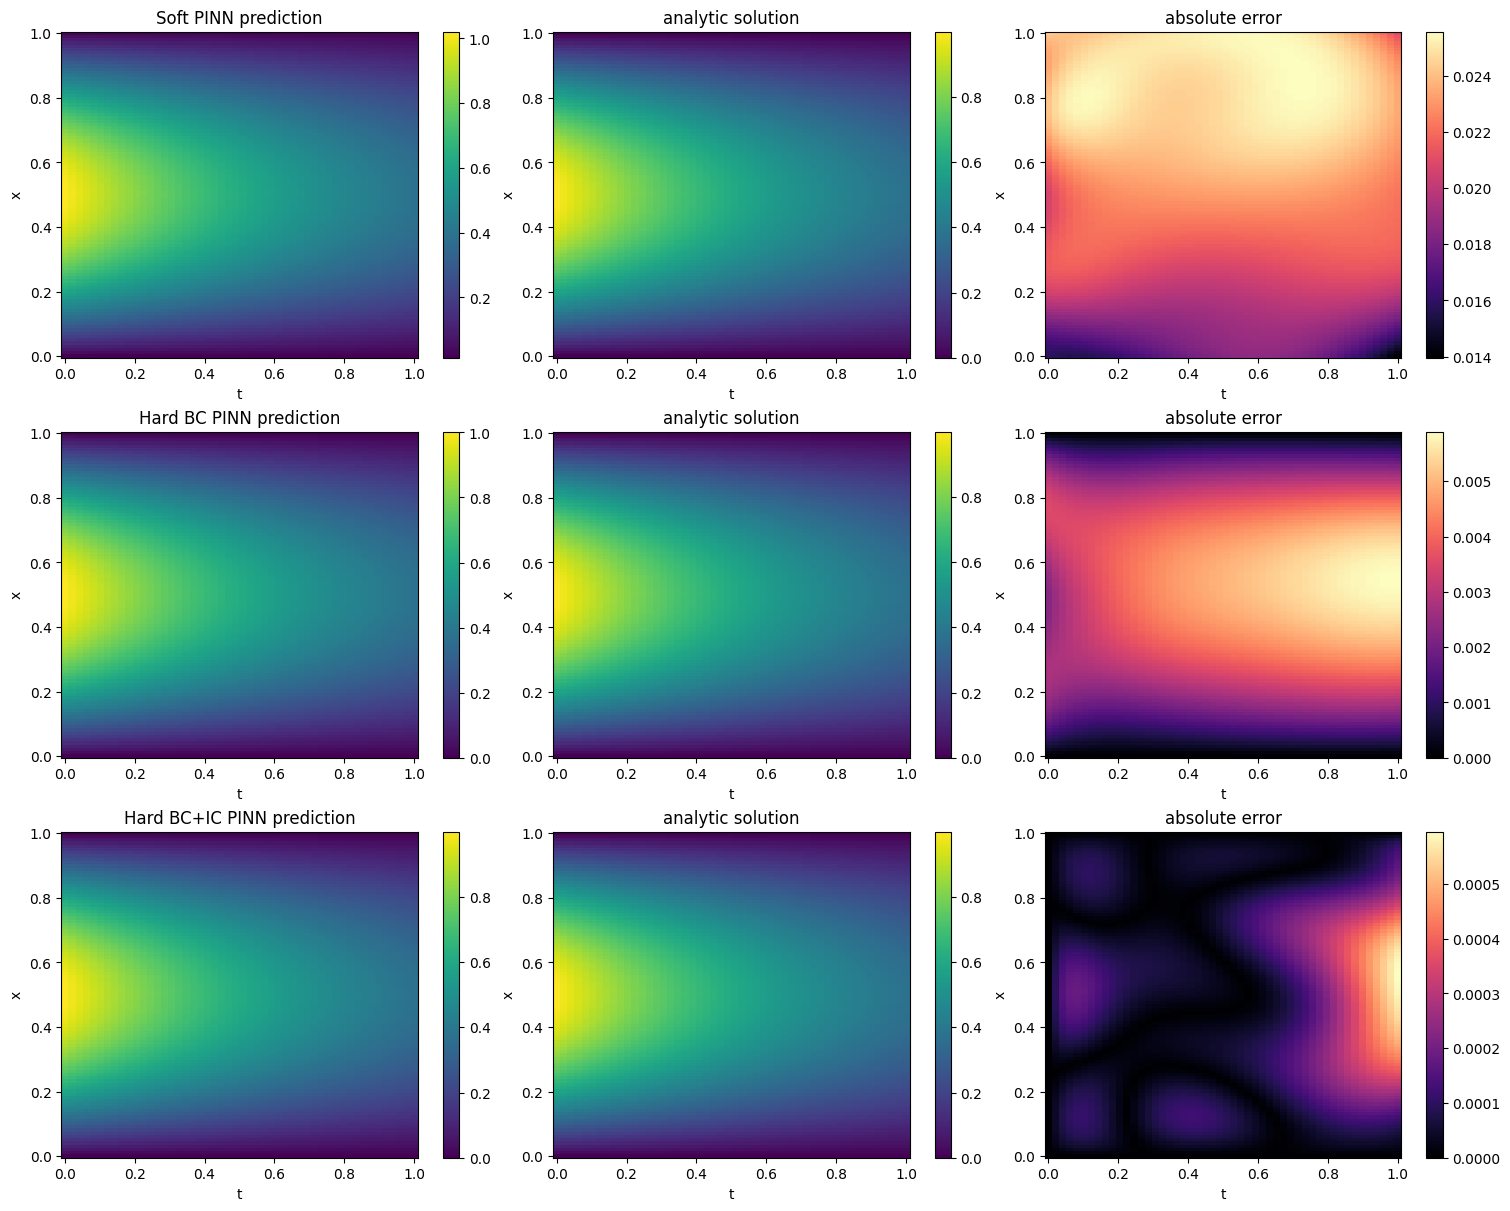

In [20]:
def plot_heatmaps(X, T, prediction, truth, error, title_prefix, axes_row):
    im0 = axes_row[0].pcolormesh(T, X, prediction, shading="auto", cmap="viridis")
    axes_row[0].set_title(f"{title_prefix} prediction")
    axes_row[0].set_xlabel("t")
    axes_row[0].set_ylabel("x")
    plt.colorbar(im0, ax=axes_row[0])

    im1 = axes_row[1].pcolormesh(T, X, truth, shading="auto", cmap="viridis")
    axes_row[1].set_title("analytic solution")
    axes_row[1].set_xlabel("t")
    axes_row[1].set_ylabel("x")
    plt.colorbar(im1, ax=axes_row[1])

    im2 = axes_row[2].pcolormesh(T, X, error, shading="auto", cmap="magma")
    axes_row[2].set_title("absolute error")
    axes_row[2].set_xlabel("t")
    axes_row[2].set_ylabel("x")
    plt.colorbar(im2, ax=axes_row[2])

Xs, Ts, soft_pred, soft_true, soft_err = soft_eval
Xh, Th, hard_pred, hard_true, hard_err = hard_eval
Xhi, Thi, hard_ic_pred, hard_ic_true, hard_ic_err = hard_ic_eval

fig, axes = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)
plot_heatmaps(Xs, Ts, soft_pred, soft_true, soft_err, "Soft PINN", axes[0])
plot_heatmaps(Xh, Th, hard_pred, hard_true, hard_err, "Hard BC PINN", axes[1])
plot_heatmaps(Xhi, Thi, hard_ic_pred, hard_ic_true, hard_ic_err, "Hard BC+IC PINN", axes[2])
plt.show()


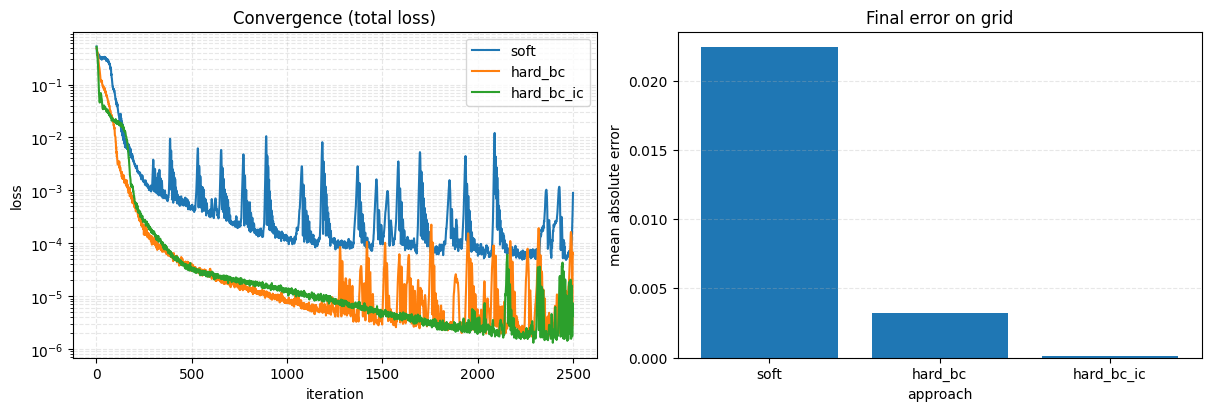

In [21]:
def history_to_frame(history, label):
    frame = pd.DataFrame(history)
    frame["label"] = label
    return frame

soft_df = history_to_frame(soft_history, "soft")
hard_df = history_to_frame(hard_history, "hard_bc")
hard_ic_df = history_to_frame(hard_ic_history, "hard_bc_ic")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].plot(soft_df["step"], soft_df["loss"], label="soft")
axes[0].plot(hard_df["step"], hard_df["loss"], label="hard_bc")
axes[0].plot(hard_ic_df["step"], hard_ic_df["loss"], label="hard_bc_ic")
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("loss")
axes[0].set_yscale("log")
axes[0].set_title("Convergence (total loss)")
axes[0].legend()
axes[0].grid(True, which="both", ls="--", alpha=0.3)

def mean_abs_error(eval_tuple):
    return float(jnp.mean(eval_tuple[4]))

error_frame = pd.DataFrame(
    {
        "label": ["soft", "hard_bc", "hard_bc_ic"],
        "mae": [
            mean_abs_error(soft_eval),
            mean_abs_error(hard_eval),
            mean_abs_error(hard_ic_eval),
        ],
    }
)

axes[1].bar(error_frame["label"], error_frame["mae"])
axes[1].set_xlabel("approach")
axes[1].set_ylabel("mean absolute error")
axes[1].set_title("Final error on grid")
axes[1].grid(True, axis="y", ls="--", alpha=0.3)

plt.show()


**Impact of hard constraints on convergence and accuracy**

The comparison between soft and hard constraint formulations reveals that strictly enforcing physical conditions significantly improves model performance. As shown in the convergence plot, the fully constrained model (`hard_bc_ic`) achieves the lowest loss and fastest convergence. This is because the optimization landscape is simplified; the network is restricted to a subspace of functions that naturally satisfy both boundary and initial conditions, allowing the optimizer to focus exclusively on minimizing the PDE residual.

Consequently, this translates to superior accuracy. The final Mean Absolute Error (MAE) is lowest for the `hard_bc_ic` approach. In contrast, the `soft` approach suffers from competing objectives in the loss function, resulting in non-zero approximation errors at the boundaries and  that propagate into the domain. Therefore, encoding the initial condition  directly into the network architecture (via a distance-function ansatz) is the most effective strategy for solving the 1D heat equation in this setup.